In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os
import pandas as pd
pd.set_option('display.max_columns', None)

from astropy.coordinates import SkyCoord
from scipy.stats import chi2
from scipy.optimize import minimize
from astropy.table import Table

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/lst1_systematics/scripts"))
import auxiliar as aux
import geometry as geom

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# ============================ #
dict_path = "objects/dict_total.pkl"
# ============================ #


#######################################
# intensity integration limits
#######################################

int_lim = [100, 400] #p.h.
rates_fixed_point = 60 # counts 

#######################################

### Reading all the objects and putting all the information in a unique dict

In [2]:
%%time
# reading dict
with open(dict_path, 'rb') as f:
    dict_total = pickle.load(f)

dict_runs    = dict_total["run"]
dict_general = dict_total["general"] 

Ibins  = dict_total["general"]["intensity_bins"]
IbinsC = dict_total["general"]["intensity_bins_centers"]

total_zds = [dict_runs[run]["zd"] for run in dict_runs.keys()]

# select the bins that are inside the integral
flag_bins = []
for i in range(len(Ibins)-1):
    if Ibins[i] > np.log10(int_lim[0]) and Ibins[i+1] < np.log10(int_lim[1]):
        flag_bins.append(True)
    else:
        flag_bins.append(False)

CPU times: user 4.66 ms, sys: 2.97 ms, total: 7.63 ms
Wall time: 15.7 ms


### Effective time correction

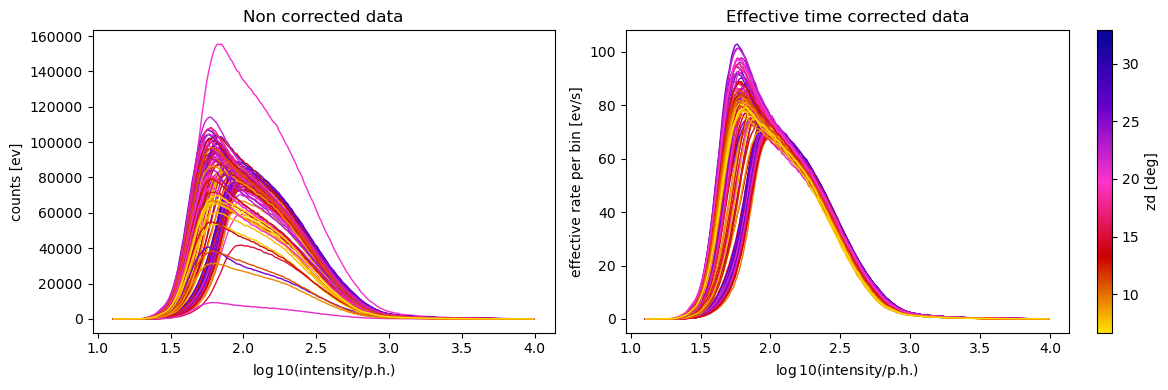

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.2]})

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax1.plot(IbinsC, dict_runs[run]["intensity_rates"] * dict_runs[run]["effective_time"], color=colors[i], lw=1)
    ax2.plot(IbinsC, dict_runs[run]["intensity_rates"]                                   , color=colors[i], lw=1)

# creating a colorbar
aux.plot_colorbar(fig, ax2, total_zds, cmap, label="zd [deg]")

for ax in [ax1, ax2]:
    ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax1.set_ylabel("counts [ev]")
ax2.set_ylabel("effective rate per bin [ev/s]")
ax1.set_title("Non corrected data")
ax2.set_title("Effective time corrected data")
fig.tight_layout()
plt.show()

### Computing counts

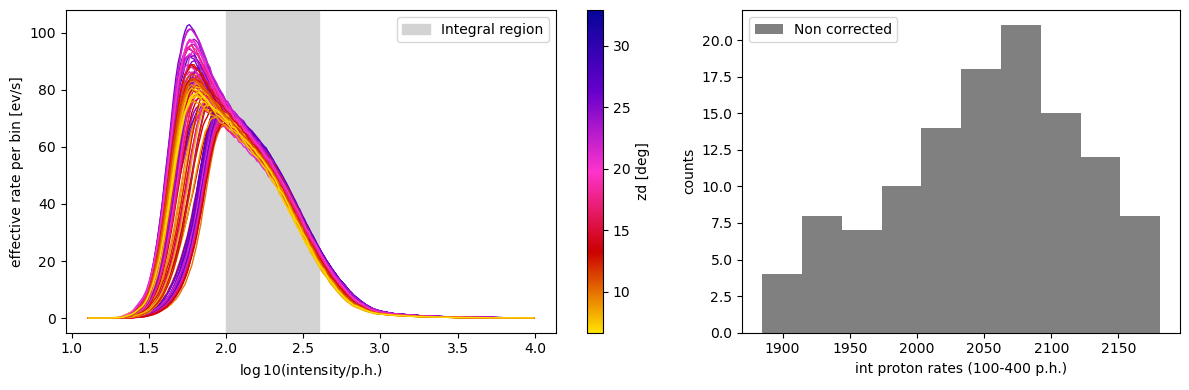

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1.4, 1]})

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
p_rate = []
for i, run in enumerate(dict_runs.keys()):  
    
    rates = dict_runs[run]["intensity_rates"]
    ax1.plot(IbinsC, rates, color=colors[i], lw=1)
    
    # --- Compute the integral of p rate in the integral range --- #
    integral = np.sum(rates[flag_bins])
    
    dict_runs[run]["p_rate"] = integral
    p_rate.append(integral)
    
# creating a colorbar
aux.plot_colorbar(fig, ax1, total_zds, cmap, label="zd [deg]")

# Plotting the integral range
ax1.axvspan(np.log10(int_lim[0]), np.log10(int_lim[1]), color="lightgray", zorder=-10, label="Integral region")

# Plotting the proton rate histogram
ax2.hist(p_rate, color="gray", bins=int(np.sqrt(len(p_rate))), label="Non corrected")

for ax in [ax1, ax2]:
    ax.legend()
ax1.set_xlabel("$\log10($intensity/p.h.$)$")
ax2.set_xlabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.h.)")
ax1.set_ylabel("effective rate per bin [ev/s]")
ax2.set_ylabel("counts")
fig.tight_layout()
plt.show()

### Extracting all the values in arrays

In [5]:
# extracting values as arrays
p_rate, e_p_rate = [], []
flux,   e_flux   = [], []
zd,     az       = [], []
e_zd,   e_az     = [], []

for run in np.sort(list(dict_runs.keys())):
    flux.append(dict_runs[run]["flux"])
    e_flux.append(dict_runs[run]["e_flux"])
    zd.append(dict_runs[run]["zd"])
    az.append(dict_runs[run]["az"])
    p_rate.append(dict_runs[run]["p_rate"])
    
    _e_p_rate = np.sqrt(dict_runs[run]["n_events"]) / dict_runs[run]["effective_time"]
    dict_runs[run]["e_p_rate"] = _e_p_rate
    e_p_rate.append(_e_p_rate)

for array in [flux, e_flux, p_rate, e_p_rate, zd, az]:
    array = np.array(array)

### Linearly fitting the zd to the proton rate and showing all distributions

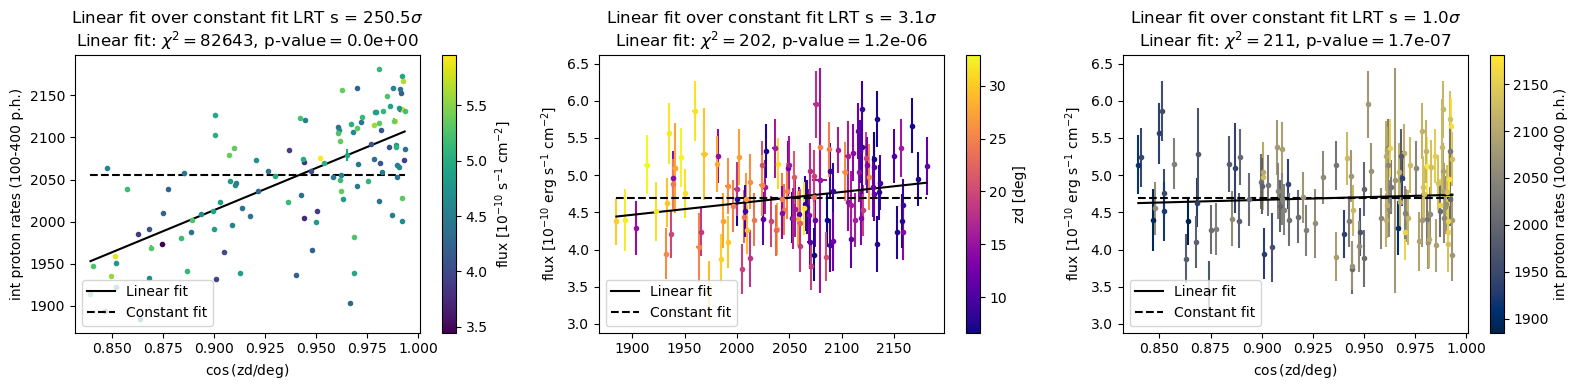

In [16]:
# Perform linear fits
fitF_zd_p = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), p_rate, 1)) 
fitF_p_f  = np.poly1d(np.polyfit(p_rate,                 flux,   1)) 
fitF_zd_f = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), flux,   1))

############################################
# plot the figures
############################################
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

norm_zd, colors_zd = aux.get_cmap_colors(zd, "plasma") 
norm_p,  colors_p  = aux.get_cmap_colors(p_rate, "cividis") 
norm_f,  colors_f  = aux.get_cmap_colors(flux, "viridis")

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i], xerr=0,           yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(p_rate[i],                 flux[i],   xerr=e_p_rate[i], yerr=e_flux[i],   ls="", marker=".", color=colors_zd[i])
    ax3.errorbar(np.cos(np.deg2rad(zd[i])), flux[i],   xerr=0,           yerr=e_flux[i],   ls="", marker=".", color=colors_p[i])

# colorbars
aux.plot_colorbar(fig, ax1, flux,   "viridis",  label="flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
aux.plot_colorbar(fig, ax2, zd,     "plasma", label="zd [deg]")
aux.plot_colorbar(fig, ax3, p_rate, "cividis", label=f"int proton rates ({int_lim[0]}-{int_lim[1]} p.h.)")

# plot lines
zd_array = np.linspace(min(np.cos(np.deg2rad(zd))), max(np.cos(np.deg2rad(zd))), 200)
p_array  = np.linspace(min(p_rate), max(p_rate), 200)

LRT_zd_p = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), p_rate, e_p_rate)
LRT_p_f  = geom.LRTFreeConst(p_rate,                 flux,   e_flux)
LRT_zd_f = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), flux,   e_flux)

ch_zd_p, _, p_zd_p = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), p_rate, e_p_rate, geom.lineFreeF, LRT_zd_p[1])
ch_p_f,  _, p_p_f  = aux.calculate_chi2_pvalue_fun(p_rate,                 flux,   e_flux,   geom.lineFreeF, LRT_p_f[1])
ch_zd_f, _, p_zd_f = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), flux,   e_flux,   geom.lineFreeF, LRT_zd_f[1])

for ax, LRT, arr, ch, p in zip([ax1, ax2, ax3], [LRT_zd_p, LRT_p_f, LRT_zd_f], [zd_array, p_array, zd_array], [ch_zd_p, ch_p_f, ch_zd_f], [p_zd_p, p_p_f, p_zd_f]):
    
    ax.plot(arr, geom.lineFreeF(LRT[1],  arr), '-k',  label=f"Linear fit")
    ax.plot(arr, geom.lineConstF(LRT[2], arr), '--k', label=f"Constant fit")
    
    ax.legend(loc=3)
    ax.set_title(f"Linear fit over constant fit LRT s = {LRT[0]:.1f}{aux.sigma}\nLinear fit: $\chi^2=${ch:.0f}, p-value$=${p:.1e}")
    
    if ax == ax1 or ax == ax2:
        ax.set_ylabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.h.)")
    if ax == ax2 or ax == ax3:
        ax.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
    if ax == ax1 or ax == ax3:
        ax.set_xlabel("$\cos$(zd/deg)")


fig.tight_layout()
plt.show()

### Re-scaling the proton rate as it should be in zd=0

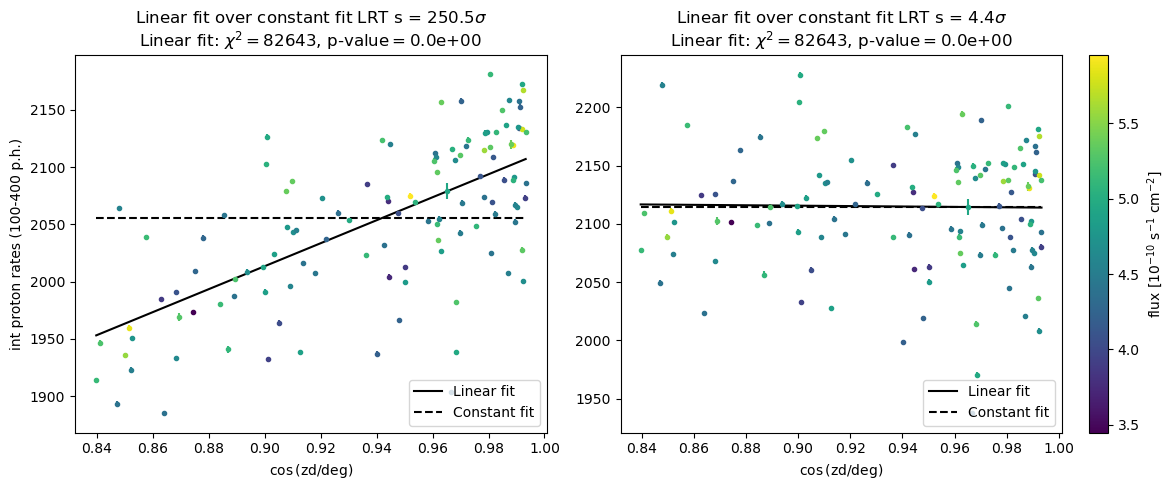

In [17]:
zd_0_p_rate = []
for run in dict_runs.keys():
    
    _zd_0_p_rate = dict_runs[run]["p_rate"] - fitF_zd_p(np.cos(np.deg2rad(dict_runs[run]["zd"]))) + fitF_zd_p(1)
    
    dict_runs[run]["zd_0_p_rate"] = _zd_0_p_rate
    zd_0_p_rate.append(_zd_0_p_rate)

    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.4]})

norm_f,  colors_f  = aux.get_cmap_colors(flux, "viridis")

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i],      xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(np.cos(np.deg2rad(zd[i])), zd_0_p_rate[i], xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])

aux.plot_colorbar(fig, ax2, flux, "viridis",  label="flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")

# plot lines
LRT_zd_p   = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), p_rate,      e_p_rate)
LRT_zd_0_p = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate)

ch_zd_p,   _, p_zd_p   = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), p_rate,      e_p_rate, geom.lineFreeF, LRT_zd_p[1])
ch_zd_0_p, _, p_zd_0_p = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate, geom.lineFreeF, LRT_zd_0_p[1])

for ax, LRT in zip([ax1, ax2], [LRT_zd_p, LRT_zd_0_p]):   
    ax.plot(zd_array, geom.lineFreeF( LRT[1], zd_array), '-k',  label=f"Linear fit")
    ax.plot(zd_array, geom.lineConstF(LRT[2], zd_array), '--k', label=f"Constant fit")

for ax in [ax1, ax2]:
    ax.legend(loc=4)
    ax.set_xlabel("$\cos$(zd/deg)")
ax1.set_ylabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.h.)")
ax1.set_title("Original proton rates")
ax2.set_title("ZD corrected proton rates")

for ax, LRT, ch, p in zip([ax1, ax2], [LRT_zd_p, LRT_zd_0_p], [ch_zd_p, ch_zd_0_p], [p_zd_p, p_zd_0_p]):
    ax.set_title(f"Linear fit over constant fit LRT s = {LRT[0]:.1f}{aux.sigma}\nLinear fit: $\chi^2=${ch:.0f}, p-value$=${p:.1e}")

fig.tight_layout()
plt.show()

### Fitting the flux vs the proton rate with a stright line passing trough (0,0)

In [48]:
LRT_p_f   = geom.LRTFreeZero(p_rate,      flux, e_flux)
LRT_0_p_f = geom.LRTFreeZero(zd_0_p_rate, flux, e_flux)
    
zd_corr_flux = []
for run in dict_runs.keys():
    _factor = geom.lineZeroF(dict_runs[run]["zd_0_p_rate"], LRT_0_p_f[2]) / dict_runs[run]["flux"]
    dict_runs[run]["zd_corr"] = _factor
    
    _zd_corr_flux = dict_runs[run]["flux"] - (geom.lineZeroF(dict_runs[run]["zd_0_p_rate"], LRT_0_p_f[2]) - np.mean(flux))
    
    zd_corr_flux.append(_zd_corr_flux[0])
    dict_runs[run]["zd_corr_flux"] = _zd_corr_flux[0]

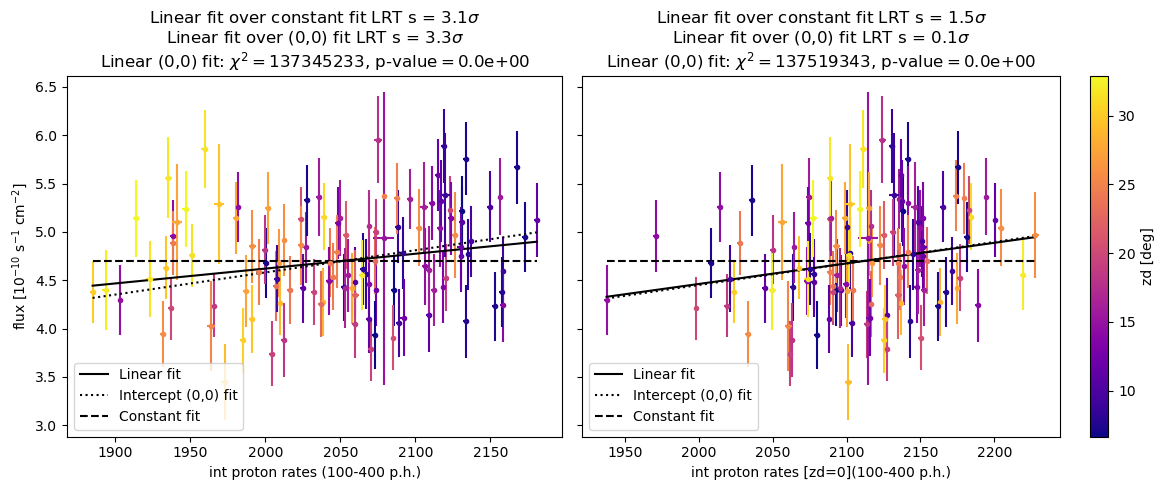

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.45]}, sharey=True)

norm_zd, colors_zd = aux.get_cmap_colors(zd, "plasma") 

for i in range(len(az)):
    ax1.errorbar(p_rate[i],      flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
    ax2.errorbar(zd_0_p_rate[i], flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])

aux.plot_colorbar(fig, ax2, zd,     "plasma", label="zd [deg]")


p_array      = np.linspace(min(p_rate),      max(p_rate),      200)
corr_p_array = np.linspace(min(zd_0_p_rate), max(zd_0_p_rate), 200)

LRT_p_f        = geom.LRTFreeConst(p_rate,      flux, e_flux)
LRT_corr_p_f   = geom.LRTFreeConst(zd_0_p_rate, flux, e_flux)
LRT_p_f_0      = geom.LRTFreeZero(p_rate,       flux, e_flux)
LRT_corr_p_f_0 = geom.LRTFreeZero(zd_0_p_rate,  flux, e_flux)

ch_zd_0_p,      _, p_zd_0_p      = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate, geom.lineFreeF, LRT_p_f_0[1])
ch_corr_zd_0_p, _, p_corr_zd_0_p = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate, geom.lineFreeF, LRT_corr_p_f_0[1])


for ax, LRT1, LRT2, LRTa, LRTb, parr, ch, p in zip([ax1, ax2], [LRT_p_f, LRT_corr_p_f], [LRT_p_f_0, LRT_corr_p_f_0], [LRT_p_f, LRT_p_f_0], [LRT_corr_p_f, LRT_corr_p_f_0],
                                                   [p_array, corr_p_array], [ch_zd_0_p, ch_corr_zd_0_p], [p_zd_0_p, p_corr_zd_0_p]):

    ax.plot(parr, geom.lineFreeF(LRT1[1],  parr), '-k',  label=f"Linear fit")
    ax.plot(parr, geom.lineZeroF(LRT2[2],  parr), ':k',  label=f"Intercept (0,0) fit")
    ax.plot(parr, geom.lineConstF(LRT1[2], parr), '--k', label=f"Constant fit")
    
    ax.legend(loc=3)
    _title = f"Linear fit over constant fit LRT s = {LRTa[0]:.1f}{aux.sigma}\nLinear fit over (0,0) fit LRT s = {LRTb[0]:.1f}{aux.sigma}"
    _title = _title + f"\nLinear (0,0) fit: $\chi^2=${ch:.0f}, p-value$=${p:.1e}"
    ax.set_title(_title)
    
ax1.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
ax1.set_xlabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.h.)")
ax2.set_xlabel(f"int proton rates [zd=0]({int_lim[0]}-{int_lim[1]} p.h.)")

fig.tight_layout()
plt.show()

### Plotting the corrections

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

norm_zd, colors_zd = aux.get_cmap_colors(zd, "plasma") 

for i in range(len(az)):
    ax.errorbar(zd_0_p_rate[i], flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])

aux.plot_colorbar(fig, ax, zd,     "plasma", label="zd [deg]")

p_array      = np.linspace(min(p_rate),      max(p_rate),      200)
corr_p_array = np.linspace(min(zd_0_p_rate), max(zd_0_p_rate), 200)

LRT_p_f        = geom.LRTFreeConst(p_rate,      flux, e_flux)
LRT_corr_p_f   = geom.LRTFreeConst(zd_0_p_rate, flux, e_flux)
LRT_p_f_0      = geom.LRTFreeZero(p_rate,       flux, e_flux)
LRT_corr_p_f_0 = geom.LRTFreeZero(zd_0_p_rate,  flux, e_flux)

ch_zd_0_p,      _, p_zd_0_p      = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate, geom.lineFreeF, LRT_p_f_0[1])
ch_corr_zd_0_p, _, p_corr_zd_0_p = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate, geom.lineFreeF, LRT_corr_p_f_0[1])


for ax, LRT1, LRT2, LRTa, LRTb, parr, ch, p in zip([ax1, ax2], [LRT_p_f, LRT_corr_p_f], [LRT_p_f_0, LRT_corr_p_f_0], [LRT_p_f, LRT_p_f_0], [LRT_corr_p_f, LRT_corr_p_f_0],
                                                   [p_array, corr_p_array], [ch_zd_0_p, ch_corr_zd_0_p], [p_zd_0_p, p_corr_zd_0_p]):

    ax.plot(parr, geom.lineFreeF(LRT1[1],  parr), '-k',  label=f"Linear fit")
    ax.plot(parr, geom.lineZeroF(LRT2[2],  parr), ':k',  label=f"Intercept (0,0) fit")
    ax.plot(parr, geom.lineConstF(LRT1[2], parr), '--k', label=f"Constant fit")
    
    ax.legend(loc=3)
    _title = f"Linear fit over constant fit LRT s = {LRTa[0]:.1f}{aux.sigma}\nLinear fit over (0,0) fit LRT s = {LRTb[0]:.1f}{aux.sigma}"
    _title = _title + f"\nLinear (0,0) fit: $\chi^2=${ch:.0f}, p-value$=${p:.1e}"
    ax.set_title(_title)
    
ax1.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
ax1.set_xlabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.h.)")
ax2.set_xlabel(f"int proton rates [zd=0]({int_lim[0]}-{int_lim[1]} p.h.)")

fig.tight_layout()
plt.show()

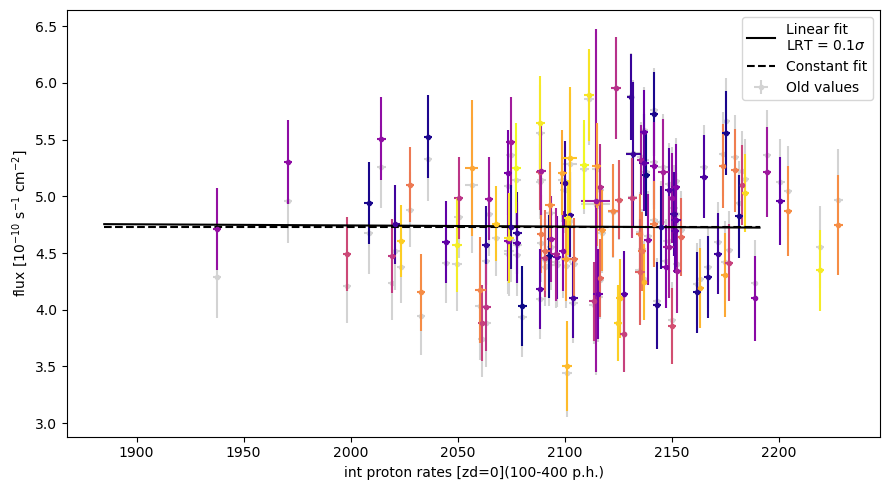

In [56]:
fitF_p_cf  = np.poly1d(np.polyfit(p_rate, zd_corr_flux, 1)) 
fitF_cp_cf = np.poly1d(np.polyfit(zd_0_p_rate, zd_corr_flux, 1)) 

fig, (ax) = plt.subplots(figsize=(9, 5))

norm_zd   = mpl.colors.Normalize(vmin=np.min(zd), vmax=np.max(zd))
colors_zd = mpl.cm.ScalarMappable(norm_zd,"plasma").to_rgba(zd)

for i in range(len(az)):
    ax.errorbar(zd_0_p_rate[i], zd_corr_flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
ax.errorbar(zd_0_p_rate, flux, xerr=e_p_rate, yerr=e_flux, ls="", marker=".", color="lightgray", zorder=-10, label="Old values")

#######################################
# creating a colorbar
sm_zd  = plt.cm.ScalarMappable(cmap="plasma", norm=norm_zd)
sm_zd.set_array([])
fig.colorbar(sm_zd, ax=ax2, label="zd [deg]")
#######################################
p_array = np.linspace(min(p_rate), max(p_rate)+10, 200)
LRT_p_f      = geom.LRTFreeConst(p_rate,      zd_corr_flux, e_flux)
LRT_corr_p_f = geom.LRTFreeConst(zd_0_p_rate, zd_corr_flux, e_flux)

ax.plot(p_array, geom.lineFreeF(LRT_corr_p_f[1], p_array), '-k', label=f"Linear fit\nLRT = {LRT_corr_p_f[0]:.1f}{aux.sigma}")
ax.plot(p_array, geom.lineConstF(LRT_corr_p_f[2], p_array), '--k', label=f"Constant fit")

ax.legend()
ax.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
ax.set_xlabel(f"int proton rates [zd=0]({int_lim[0]}-{int_lim[1]} p.h.)")

fig.tight_layout()
plt.show()

### Plotting the Light Curve

In [ ]:
chi, zd_corr_chi = [], []

for run in dict_runs.keys():
    if run > 0:
        chi.append((dict_runs[run]["flux"] - np.mean(flux)) / dict_runs[run]["e_flux"])
        zd_corr_chi.append((dict_runs[run]["zd_corr_flux"] - np.mean(zd_corr_flux)) / dict_runs[run]["e_flux"])


units = "[e-10 erg / (s cm2)]"
print(f"Flux original       = {np.mean(flux):.3f} ± {np.std(flux):.3f}   {units}")
print(f"Flux zd correction  = {np.mean(zd_corr_flux):.3f} ± {np.std(zd_corr_flux):.3f}   {units}")

fig, ax = plt.subplots(figsize=(15, 3))

for i, run in enumerate(dict_runs.keys()):  

    if i == 0:
        label = "Original flux curve"
        label_zd  = "Proton rate corrected"
    else:   
        label, label_zd = None, None
        
    errors = dict_runs[run]["e_flux"]
    flux_value         = dict_runs[run]["flux"]
    zd_corr_flux_value = dict_runs[run]["zd_corr_flux"]
    
    ax.errorbar(i, flux_value,         yerr=errors, marker="o", ls="", color="gray",  zorder=-10, label=label)
    ax.errorbar(i, zd_corr_flux_value, yerr=errors, marker=".", ls="", color="crimson", label=label_zd)

ax.axhline(np.mean(zd_corr_flux), color="r", ls="--", label=f"Constant fit")
    
ax.legend(loc=3, ncol=1)
ax.set_xlabel(f"Run #")
ax.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
        
chi2_arr = np.sum(np.array(chi) ** 2) 
zd_corr_chi2_arr = np.sum(np.array(zd_corr_chi) ** 2) 
        
ax.set_title(f"LRT original vs corrected {np.sqrt(chi2_arr - zd_corr_chi2_arr):.1f}{sigma}")
plt.show()

### Calculating the chi2 distributions

In [ ]:
# for N in range(40):
#     if N % 2 == 0 and N > 0:
        
N = 24
print(N)
bins = np.linspace(-6, 6, N)

fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(np.array(chi),         bins=bins, color="gray", alpha=0.7,  label=f"Original dataset stdv = {np.std(chi):.3f}")
ax.hist(np.array(chi),         bins=bins, color="k", lw=2, histtype="step")
ax.hist(np.array(zd_corr_chi), bins=bins, color="crimson", histtype="step", lw=2, label=f"zd correction      stdv = {np.std(zd_corr_chi):.3f}")


# ax.legend()
plt.grid()
ax.set_ylabel("Counts")
ax.set_xlabel("(flux - mean(flux)) / error(flux)")
plt.show()

In [ ]:
INT = []
bins_fixed = []

fig, ax = plt.subplots(figsize=(10, 5))

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), binsI)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    
    C = dict_runs[run]["zd_corr_flux"] / dict_runs[run]["flux"]
    
    counts   = counts / dict_dl2[run]["effective_time"]  * C
    
    ax.plot(Icenters, counts, color=color, lw=1)

    integral = 0
    for i, b in enumerate(binsI[:-1]):
        if binsI[i] > np.log10(intensity_integration_lims[0]) and binsI[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]
    INT.append(integral)

    for i in range(len(binsI)-1):
        if binsI[i] > 2.:
            if counts[i] > rates_fixed_point and counts[i+1] <= rates_fixed_point:
                _bin_center = binsI[i]/2 + binsI[i+1]/2
                bins_fixed.append(_bin_center) 
                dict_runs[run]["int_at_fixed_rate"] = _bin_center
        
bins_fixed = np.array(bins_fixed)
INT = np.array(INT)

ax.axhline(rates_fixed_point,   color="k", ls=":", label="Fixed rate")
ax.axvline(np.mean(bins_fixed), color="k", ls="--", label="Mean intensity at fixed counts rate")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1.2, 1.4]})

bins = np.linspace(np.min(p_rate), np.max(p_rate), 25)
ax1.hist(p_rate, bins, color="gray")
ax1.hist(INT, bins, color="red", alpha=0.5)

norm   = mpl.colors.Normalize(vmin=np.min(INT), vmax=np.max(INT))
colors = mpl.cm.ScalarMappable(norm,"plasma").to_rgba(INT)
for i in range(len(az)):
    ax2.errorbar(az[i], zd[i], xerr=e_az[i], yerr=e_zd[i], ls="", marker=".", color=colors[i])

#######################################
# creating a colorbar
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
#######################################

ax1.set_ylabel("Counts")
ax1.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel("az [deg]")
ax2.set_ylabel("zd [deg]")
plt.show()

In [ ]:
bb = binsI-np.mean(bins_fixed)

In [ ]:
fig, ax1 = plt.subplots(figsize=(5, 4))

ax1.hist(bins_fixed, bins=binsI, color="darkblue")
ax1.set_xlim(2.13, 2.24)

ax1.set_ylabel("Counts")
ax1.set_xlabel(f"log10(intensity/p.h.)")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), binsI)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    
    C = dict_runs[run]["zd_corr_flux"] / dict_runs[run]["flux"]
    
    counts   = counts / dict_dl2[run]["effective_time"]  * C
    
    D = np.mean(bins_fixed) - dict_runs[run]["int_at_fixed_rate"]
    Icenters = Icenters + D
    ax.plot(Icenters, counts, color=color, lw=1)

                
ax.axhline(rates_fixed_point,   color="k", ls=":", label="Fixed rate")
ax.axvline(np.mean(bins_fixed), color="k", ls="--", label="Mean intensity at fixed counts rate")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()